<a href="https://colab.research.google.com/github/yjm4599/awesome-artificial-intelligence/blob/master/Image_Segmentation(%EC%A0%84%EB%B3%91%ED%99%98_%EA%B5%90%EC%88%98%EB%8B%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 분할 (Segmentation)


*   RedNet을 이용하여 이미지 분할 무제에 적용해보기
*   oxford Pet Dataset 불러오기



In [27]:
import tensorflow_datasets as tfds

!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2020-08-03 05:40:53.508629: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
I0803 05:40:55.483955 140589362399104 download_and_prepare.py:180] Running download_and_prepare for datasets:
oxford_iiit_pet:3.1.0
I0803 05:40:55.484619 140589362399104 download_and_prepare.py:181] Version: "None"
I0803 05:40:55.485283 140589362399104 dataset_builder.py:199] Overwrite dataset info from restored data version.
I0803 05:40:55.488262 140589362399104 download_and_prepare.py:130] download_and_prepare for dataset oxford_iiit_pet/3.1.0...
I0803 05:40:55.488541 140589362399104 dataset_builder.py:285] Reusing dataset oxford_iiit_pet (/root/tensorflow_datasets/oxford_iiit_pet/3.1.0)
name: "oxford_iiit_pet"
description: "The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200\nimages for each class. The images have large variations in scale, pose and\nlighting. All images have an associated ground truth annotatio

In [28]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.1.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and J

# 이미지 가져오기

*   항목 추가
*   항목 추가



In [29]:
import tensorflow as tf
import numpy as np

info.splits['train']
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples
print(train_data_len, test_data_len)

3680 3669


In [30]:
#불규칙한 이미지 차원을 균일한 차원으로 바꾸어 주는 함수
def load_image(datapoint):
  img = tf.image.resize(datapoint['image'],(128,128))
  mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

  img = tf.cast(img, tf.float32)    #자료형 변환
  img = img / 255.0            #정규화 0~1로 만듦
  mask -= 1    #마스크 레이블 기존 1, 2, 3 -> 0, 1, 2로 변경

  return img, mask

In [31]:
train_dataset = dataset['train'].map(load_image)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)


# 데이터 가시화

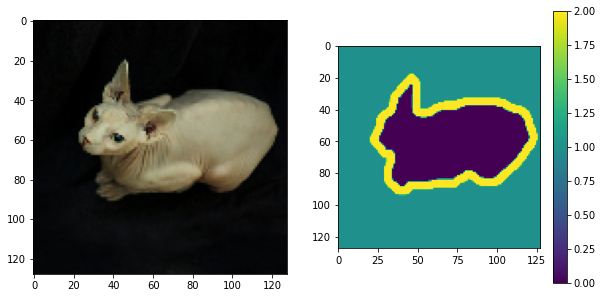

In [32]:
import matplotlib.pyplot as plt
imgIdx = 0
for img, mask in train_dataset.take(1):   #c=1개의 배치를 가져와라
  plt.figure(figsize = (10,5))

  plt.subplot(1, 2, 1)
  plt.imshow(img[imgIdx])

  plt.subplot(1, 2, 2)
  plt.imshow(np.squeeze(mask[imgIdx], axis=2))
  plt.colorbar()


#Segmentation을 위한 REDNet정의

In [33]:
def REDNet_segmentation(num_layers):
  conv_layers = []      #encoders
  deconv_layers = []    #decoders
  residual_layers = []  #skip connections
   
   #입력 레이어 정의 : None으로 해놓으면 임의의 차원을 모두 입력으로 받을 수 있음
  inputs = tf.keras.layers.Input(shape=(None, None, 3))


  #처음 입력영상 처리하는 부분은 3채널로써 먼저 conv layer하나를 미리 담아둔다.
  conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))


#중간 반복 되는 레이어들을 64채널로 고정하여 리스트에 담기
  for i in range(num_layers-1):
    conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size = 3, padding='same', activation= 'relu'))     #convolution
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size = 3, padding='same', activation= 'relu'))       #deconvolution


#마지막 출력 채널에 맞추기 위해 3채널로 Deconvolution 수행
  deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='softmax'))
  #  softmax를 추가해서 pixelwise classification문제를 해결하도록 변경됨.
  #==========총 30개의 레이어가 준비되었음===========

  #인코딩 path연결을 시작

  x= conv_layers[0](inputs)   #첫번째 레이어 먼저 처리

  for i in range(num_layers-1): #0~13
    x = conv_layers[i+1](x) #conv레이어들 쭉쭉 연결

    if i % 2 ==0: #짝수일 경우
    #skip connection으로 나중에 deconvolution할때 연결해주기위해서 중간 값들을 저장함.
      residual_layers.append(x)

  #디코딩 path연결을 시작
  for i in range(num_layers-1):
    if i % 2 == 1:  #i인덱스가 홀수라면
        x= tf.keras.layers.Add()([x, residual_layers.pop()])  #pop은 가장 마지막에 들어갔던 순서로 꺼냄
        x= tf.keras.layers.Activation('relu')(x)
    x= deconv_layers[i](x) #Deconvolution 항상 하는 것

  x = deconv_layers[-1](x)

  model = tf.keras.Model(inputs=inputs, outputs=x)



  return model

# 모델 환경설정

In [34]:
model = REDNet_segmentation(15)
model.compile(optimizer = tf.optimizers.Adam(0.001),
              loss = ['sparse_categorical_crossentropy'],        #sparse C C쓰는 이유:
              metrics=['accuracy'])

In [36]:
history = model.fit(train_dataset,
                    epochs = 1,
                    steps_per_epoch = train_data_len//16,
                    validation_data = test_dataset,
                    validation_steps = test_data_len)

230/230 [==============================] - 149s 646ms/step - loss: 0.6497 - accuracy: 0.7179 - val_loss: 0.6129 - val_accuracy: 0.7345


#가시화

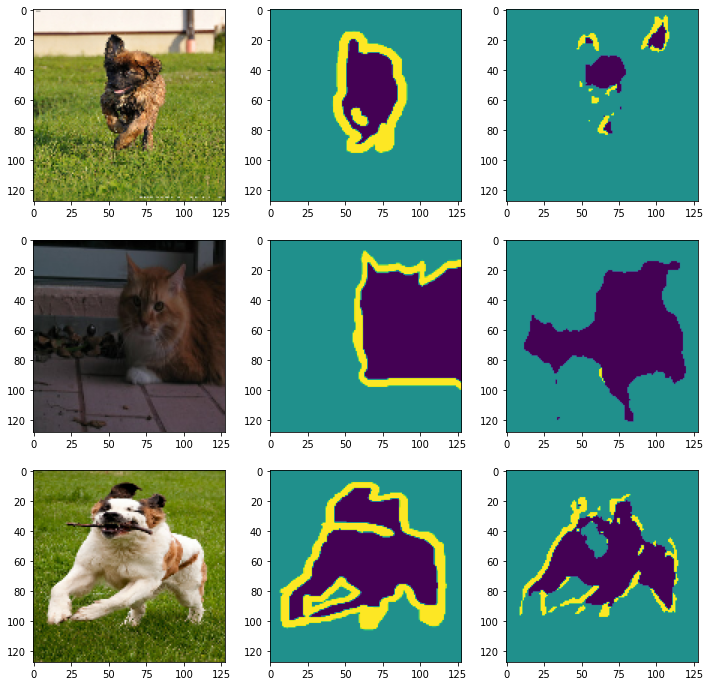

In [37]:
plt.figure(figsize=(12,12))
for idx, (img, mask) in enumerate(test_dataset.take(3)):
  plt.subplot(3,3, idx*3+1)
  plt.imshow(img[0])

  plt.subplot(3,3,idx*3+2)
  plt.imshow(np.squeeze(mask[0],axis=2))

  predict = tf.argmax(model.predict(img),axis=-1)
  plt.subplot(3,3,idx*3+3)
  plt.imshow(np.squeeze(predict,axis=0))